In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from scipy import signal
from pandasql import sqldf
import seaborn as sns
import pingouin as pg
from collections import defaultdict

# Treadmill data analysis
Quentin Decultot, JJ Aucouturier, 2021

In [3]:
# load examples 
file_1 = 'treadmill_1_21_05_06_14_24'
step_data_1 = pd.read_csv('data/backup/'+file_1+'.csv')
sound_data_1 = pd.read_csv('data/backup/'+file_1+'_sound.csv')

file_2 = 'treadmill_2_21_05_06_15_02'
step_data_2 = pd.read_csv('data/backup/'+file_2+'.csv')
sound_data_2 = pd.read_csv('data/backup/'+file_2+'_sound.csv')


## Debug

Quentin: this section lists potential issues found in the files, which should be fixed in the experimental code. 

### Time reset in file 1

File treadmill_1_21_05_06_14_24 has a pb. Headers ("time, x_left...") are inserted a second time at time = 5000, and time is reset to 0 after this position. 

In [ ]:
print(step_data_1[pd.to_numeric(step_data_1.time, errors='coerce').isnull()])

In [5]:
step_data_1.loc[4995:5005]

,time,x_left,y_left,z_left,x_right,y_right,z_right
4995,4995.06422996521,0.3898674307220942,-0.591251647693392,-2.009833909870968,-3.0451940738555447,-1.2622521112901666,-0.3461191397861185
4996,4996.06422996521,0.38477409233570015,-0.591251647693392,-2.0072872129705015,-3.0401012309403206,-1.2622521112901666,-0.3461191397861185
4997,4997.06422996521,0.38477409233570015,-0.5887048981723968,-2.0072872129705015,-3.0350083880250964,-1.2622521112901666,-0.3461191397861185
4998,4998.06422996521,0.39241409991529164,-0.5887048981723968,-2.0072872129705015,-3.0401012309403206,-1.2622521112901666,-0.3461191397861185
4999,4999.06422996521,0.4000541074948831,-0.5887048981723968,-2.0047405160700347,-3.0426476523979327,-1.2622521112901666,-0.3461191397861185
5000,time,x_left,y_left,z_left,x_right,y_right,z_right
5001,0.0637972354888916,1.0723747744989174,-0.24234696331709582,0.45536868978057754,-3.1368652463295805,-1.3845040595644278,-0.2951743396600115
5002,1.0637972354888916,0.9756013451574272,-0.2576274604430644,0.4681021742829099,-3.3049290625319796,-1.3539410724958643,-0.3155522597104543
5003,2.0637972354888916,1.0367214057941574,-0.31874944894694135,0.45536868978057754,-3.1903400969394347,-1.272439773646358,-0.3257412197356757
5004,3.0637972354888916,0.9756013451574272,-0.34676369367788507,0.4349951145768465,-3.147050932160029,-1.272439773646358,-0.3155522597104543


This creates pb when plotting data (value 'time' in col time is not a numeric (have to coerce it into a Nan), and also uncertainty as to what time should be considered (start at 5000 ? Add 5000 to all values after 5000 ?)

(-1000.0, 6000.0)

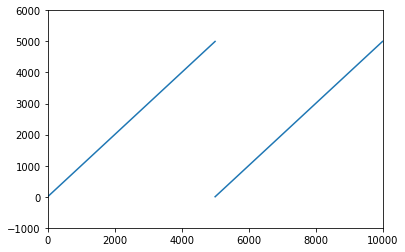

In [236]:
plt.plot(pd.to_numeric(step_data_1.time, errors='coerce'))
plt.xlim([0,10000])
plt.ylim([-1000,6000])

File treadmill_2_21_05_06_15_02 doesn't have the same problem

In [7]:
print(step_data_2[pd.to_numeric(step_data_2.time, errors='coerce').isnull()])

Empty DataFrame
Columns: [time, x_left, y_left, z_left, x_right, y_right, z_right]
Index: []


For now, simply delete data before 5000 in first file. 

In [5]:
step_data_1 = step_data_1.loc[5001:].reset_index()

In [9]:
print(step_data_1[pd.to_numeric(step_data_1.time, errors='coerce').isnull()])

Empty DataFrame
Columns: [index, time, x_left, y_left, z_left, x_right, y_right, z_right]
Index: []


## Step data analysis

The goal of this section is to segment step data corresponding to each trial/note, and to extract features from each step, resulting in a dataframe in the form of: 
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_feature</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>2.3</td>
  </tr>
  <tr>
    <td>1</td>
    <td>2</td>
    <td>Bb3</td>
    <td>0.6</td>
  </tr>
  <tr>
    <td>1</td>
    <td>...</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>1</td>
    <td>1500</td>
    <td>C#5</td>
    <td>1.8</td>
  </tr>
</tbody>
</table>

In [4]:
step_data_1 = step_data_1.loc[5001:].reset_index()
step_data_1 = step_data_1.apply(pd.to_numeric)
step_data_2 = step_data_2.apply(pd.to_numeric)
print(step_data_2)

                 time    x_left    y_left    z_left   x_right   y_right  \
0        9.884930e-02 -0.259533 -3.079426 -2.198289 -4.514479 -1.048311   
1        1.098849e+00 -0.300280 -3.038678 -2.193196 -4.455912 -0.956622   
2        2.098849e+00 -0.239160 -3.117627 -2.200836 -4.595965 -1.048311   
3        3.098849e+00 -0.114373 -3.171109 -2.205930 -4.705461 -1.048311   
4        4.098849e+00 -0.081266 -3.066692 -2.208476 -4.786946 -1.017748   
...               ...       ...       ...       ...       ...       ...   
1227195  1.227195e+06  0.366947 -0.000406 -0.907114 -0.977500  0.092707   
1227196  1.227196e+06  0.366947 -0.000406 -0.907114 -0.977500  0.092707   
1227197  1.227197e+06  0.366947 -0.000406 -0.907114 -0.977500  0.102895   
1227198  1.227198e+06  0.366947 -0.000406 -0.907114 -0.977500  0.102895   
1227199  1.227199e+06  0.366947  0.002141 -0.907114 -0.980046  0.092707   

          z_right  
0        1.773185  
1        1.773185  
2        1.773185  
3        1.773185  

### Observations

#### Irregular step timing

Quentin & JJ do not have the same timing: JJ looks a lot more irregular than Quentin. We can't assume that the sound position gives the position of the step (e.g. can't for-loop in sounds to look in step data). \
<b>Strategy:</b> first find start and end of each step in step data(e.g. on z), then try to assign each step to a sound (e.g. if sound_time is in [step_start, step_stop]), possibly skip sound when there is ambiguity.

JJ:

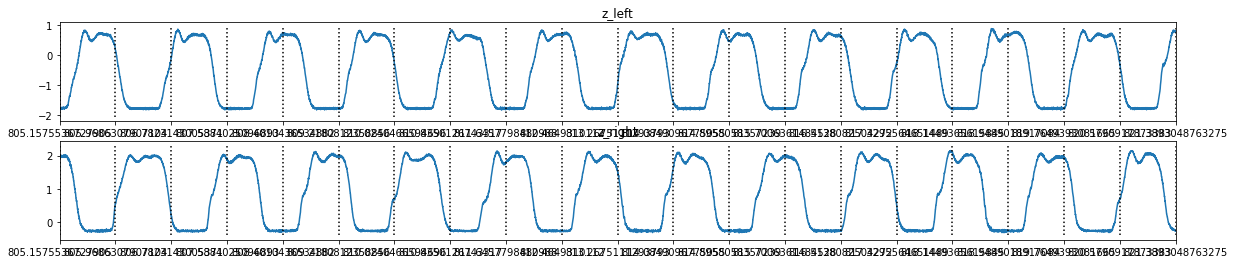

In [11]:
dims= ['z_left','z_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_1['time']/1000,step_data_1[dim])
    plt.title(dim)
    for id,row in sound_data_1.iterrows(): 
        plt.plot([row.time,row.time],[step_data_1[dim].min(),step_data_1[dim].max()],'k:')
    plt.xlim([1000,1020])


Quentin:

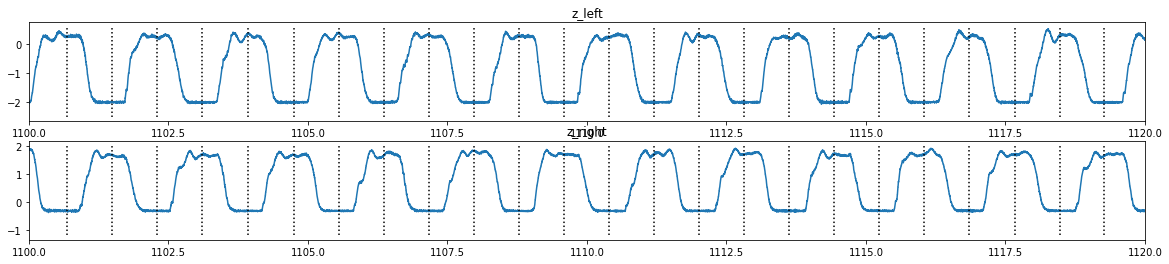

In [12]:
dims= ['z_left','z_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_2['time']/1000,step_data_2[dim])
    plt.title(dim)
    for id,row in sound_data_2.iterrows(): 
        plt.plot([row.time,row.time],[step_data_2[dim].min(),step_data_2[dim].max()],'k:')
    plt.xlim([1100,1120])


#### Step data easier to segment on z

Step data is a lot easier to segment on z_left and z_right than  x,y. \
<b>Strategy:</b> find step start/stop on z, then apply to x,y (because same timing). Note also that Y_right more noisy than Y_left. 

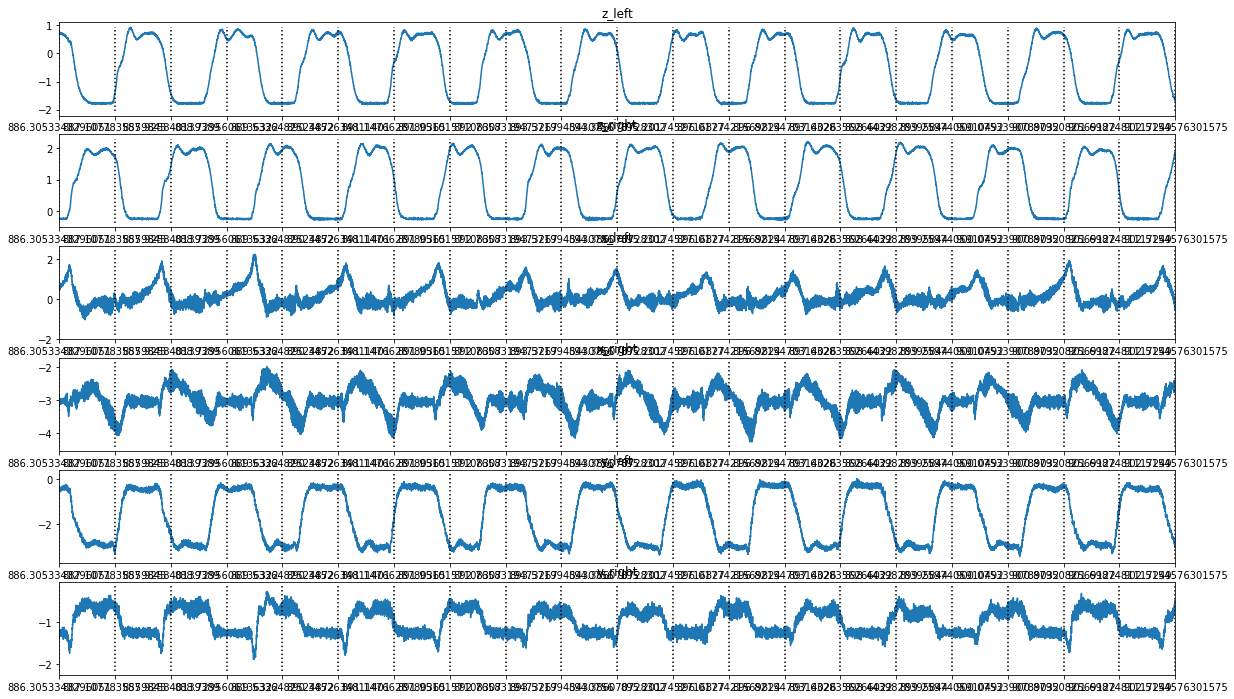

In [13]:
dims= ['z_left','z_right', 'x_left','x_right', 'y_left','y_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_1['time']/1000,step_data_1[dim])
    #plt.plot(step_data_1['time']/1000,step_data_1[dim])
    
    plt.title(dim)
    for id,row in sound_data_1.iterrows(): 
        plt.plot([row.time,row.time],[step_data_1[dim].min(),step_data_1[dim].max()],'k:')
    plt.xlim([1100,1120])


#### Resampling

Note: estimated sample rate = 1000Hz

In [14]:
len(step_data_1.time)/(step_data_1.time.max()/1000)

1000.0007719992473

In [8]:
sr = 1000

We wouldn't lose much by downsampling to 100Hz (10ms precision on the onset/duration of the step, possibly), and divide memory/cpu by 10. \
<b> Strategy: </b> For now, downsample in notebook. If this is confirmed, maybe sample at 100Hz during the experiment, and put sr in config file. 

Text(0.5, 1.0, '100Hz')

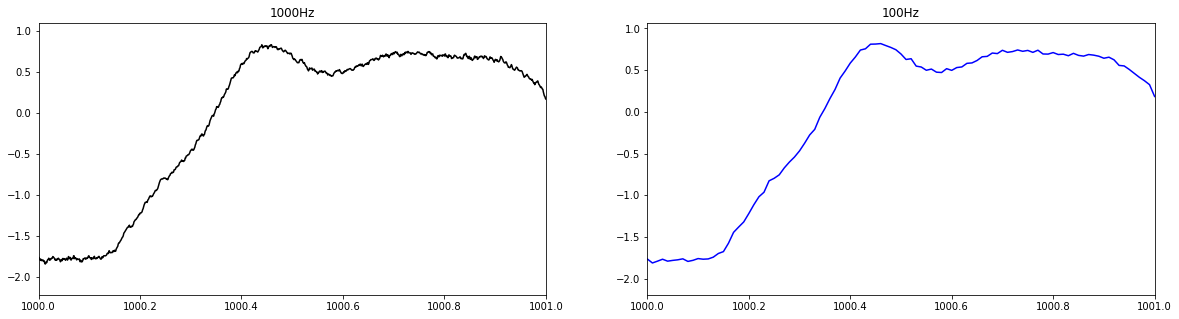

In [18]:
x = np.array(step_data_1['z_left'])
t = np.array(step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([1000, 1001])
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
new_sr = 100
(x,t)=signal.resample(x,t=t,num=int((len(x)/sr)*new_sr))
plt.plot(t/1000,x,'b')
plt.xlim([1000, 1001])
plt.title('%dHz'%new_sr)

#### Detrend

Z data has a trend, which makes using a fixed threshold to segment step impossible (min + 5% at the beginning is < min at the end)

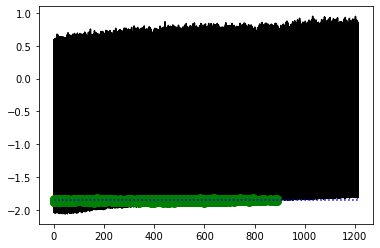

In [19]:
times= step_data_1.time
x = step_data_1.z_left

# adapt threshold to min + a percent of (range of x)
x_min = np.percentile(x,1) 
x_max = np.percentile(x,99)
percent_range = 0.05
threshold = x_min + (x_max-x_min)*percent_range
mask = np.diff(1 * (x > threshold) != 0)

plt.plot(times/1000, x, 'k')
plt.plot(times[:-1][mask]/1000,x[:-1][mask], 'go', markersize=8)
plt.plot([times.min()/1000,times.max()/1000],[threshold,threshold],'b:')
    

That trend is there for both dataset, so it's not a feature of the participant but a bug of the treadmill. \
<b> Strategy: </b> Detrend before analysis

### Preprocessing

#### Resample

In [5]:
sr = 1000

,x_left,y_left,z_left,x_right,y_right,z_right,time
0,0.208056,-1.535977,-0.555792,-2.882884,-1.010867,0.726380,5.001064e+03
1,0.569947,-0.090816,0.661268,-3.056901,-1.307236,-0.534198,5.011064e+03
2,0.521288,-0.465837,0.339104,-3.043912,-1.231721,-0.211738,5.021064e+03
3,0.682947,-0.189298,0.519945,-3.027203,-1.345853,-0.385925,5.031064e+03
4,0.558134,-0.377367,0.389114,-3.044119,-1.258233,-0.276863,5.041064e+03
...,...,...,...,...,...,...,...
120764,-0.291544,-3.182669,-1.799417,-2.513924,-0.575906,2.188448,1.212650e+06
120765,-0.280387,-3.034955,-1.719125,-2.553471,-0.582732,2.034174,1.212660e+06
120766,-0.328280,-3.181735,-1.830150,-2.567736,-0.536998,2.129444,1.212670e+06
120767,-0.199485,-2.929125,-1.641779,-2.614229,-0.668119,1.943134,1.212680e+06


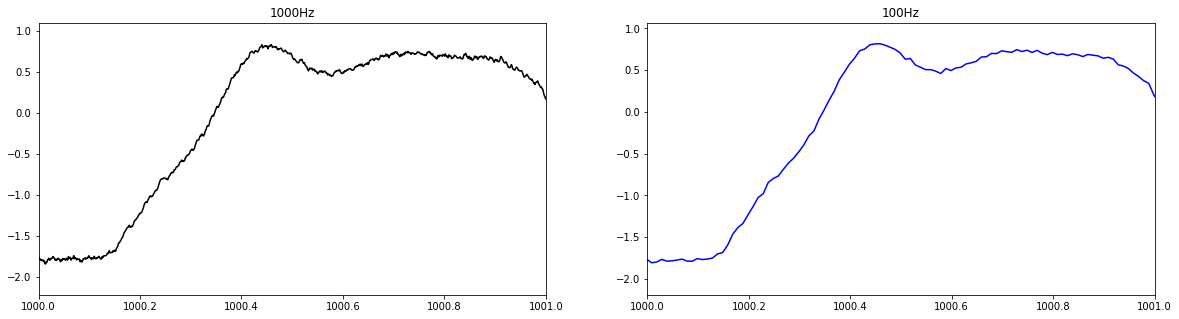

In [6]:
def resample_all_cols(df, sr, new_sr, time_col='time'): 
    # resample all cols except time_col to new_sr
    
    # list data columns (neither index nor time)
    data_cols = list(df)
    if time_col in data_cols:
        data_cols.remove(time_col)
    if 'index' in data_cols:
        data_cols.remove('index')
    
    resampled_df = pd.DataFrame()
    #data_numeric = weight_data[['time','x_left','y_left','z_left','x_right','y_right','z_right']].apply(pd.to_numeric)
    #data_parameters = weight_data[['participant','config_file','order','condition_name']]
    for data_col in data_cols: 
        data = np.array(df[data_col])
        time = np.array(df[time_col])
        (new_data,new_time) = signal.resample(data,
                                t=time,
                                num = int((len(data)/sr)*new_sr))
        resampled_df[data_col] = new_data
    resampled_df['time'] = new_time
    return resampled_df

# test
# resample to 100Hz
rs_step_data_1 = resample_all_cols(step_data_1,sr,100)
# plot original vs resampled 
x = np.array(step_data_1['z_left'])
t = np.array(step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([1000, 1001])
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
x = np.array(rs_step_data_1['z_left'])
t = np.array(rs_step_data_1['time'])
plt.plot(t/1000,x,'b')
plt.xlim([1000, 1001])
plt.title('%dHz'%100)
rs_step_data_1

,x_left,y_left,z_left,x_right,y_right,z_right,time
0,0.208056,-1.535977,-0.555792,-2.882884,-1.010867,0.726380,5.001064e+03
1,0.569947,-0.090816,0.661268,-3.056901,-1.307236,-0.534198,5.011064e+03
2,0.521288,-0.465837,0.339104,-3.043912,-1.231721,-0.211738,5.021064e+03
3,0.682947,-0.189298,0.519945,-3.027203,-1.345853,-0.385925,5.031064e+03
4,0.558134,-0.377367,0.389114,-3.044119,-1.258233,-0.276863,5.041064e+03
...,...,...,...,...,...,...,...
120764,-0.291544,-3.182669,-1.799417,-2.513924,-0.575906,2.188448,1.212650e+06
120765,-0.280387,-3.034955,-1.719125,-2.553471,-0.582732,2.034174,1.212660e+06
120766,-0.328280,-3.181735,-1.830150,-2.567736,-0.536998,2.129444,1.212670e+06
120767,-0.199485,-2.929125,-1.641779,-2.614229,-0.668119,1.943134,1.212680e+06


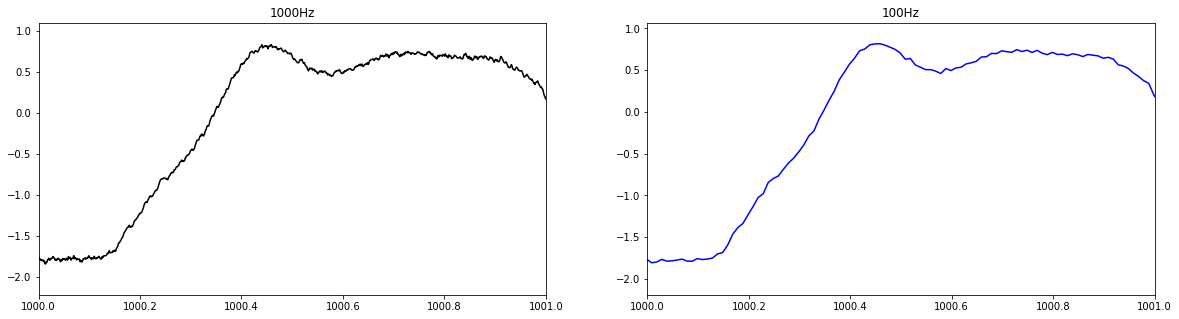

In [6]:
def resample_all_cols(df, sr, new_sr, params_col='time'): 
    # resample all cols except time_col to new_sr
    
    # list data columns (neither index nor time)
    data_cols = list(df)
    
    for col in params_col : 
        if col in data_cols:
            data_cols.remove(col)
    if 'index' in data_cols:
        data_cols.remove('index')
    
    resampled_df = pd.DataFrame()
    #data_numeric = weight_data[['time','x_left','y_left','z_left','x_right','y_right','z_right']].apply(pd.to_numeric)
    #data_parameters = weight_data[['participant','config_file','order','condition_name']]
    for data_col in data_cols: 
        data = np.array(df[data_col])
        time = np.array(df[time_col])
        (new_data,new_time) = signal.resample(data,
                                t=time,
                                num = int((len(data)/sr)*new_sr))
        resampled_df[data_col] = new_data
    resampled_df['time'] = new_time
    return resampled_df

# test
# resample to 100Hz
rs_step_data_1 = resample_all_cols(step_data_1,sr,100)
# plot original vs resampled 
x = np.array(step_data_1['z_left'])
t = np.array(step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([1000, 1001])
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
x = np.array(rs_step_data_1['z_left'])
t = np.array(rs_step_data_1['time'])
plt.plot(t/1000,x,'b')
plt.xlim([1000, 1001])
plt.title('%dHz'%100)
rs_step_data_1

#### Detrend

(-2.1, 1.0)

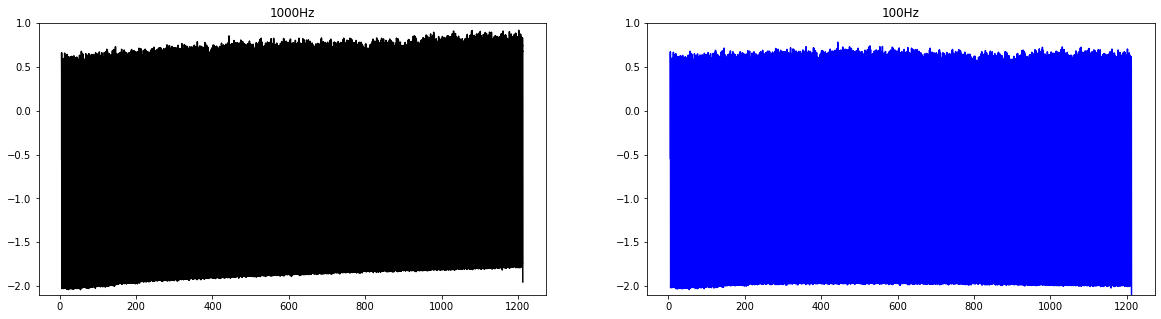

In [7]:
def detrend_all_cols(df,time_col='time'):
    # remove linear trend in data
    
    # list data columns (neither index nor time)
    data_cols = list(df)
    if time_col in data_cols:
        data_cols.remove(time_col)
    if 'index' in data_cols:
        data_cols.remove('index')
        
    detrend_df = pd.DataFrame()
    for data_col in data_cols: 
        detrend_df[data_col]=signal.detrend(np.array(df[data_col]),
                                             type='linear')
        # remove offset, to keep in the same range as beginning of series
        detrend_df[data_col]=detrend_df[data_col]-detrend_df[data_col].quantile(.01)+ df[data_col].quantile(.01)
    detrend_df['time'] = df[time_col]
    return detrend_df

# test
rs_step_data_1 = resample_all_cols(step_data_1,sr,100)
de_step_data_1 = detrend_all_cols(rs_step_data_1)

x = np.array(rs_step_data_1['z_left'])
t = np.array(rs_step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.title('%dHz'%sr)
plt.ylim([-2.1,1.0])
ax = fig.add_subplot(1,2,2)
x = np.array(de_step_data_1['z_left'])
t = np.array(de_step_data_1['time'])
plt.plot(t/1000,x,'b')
plt.title('%dHz'%100)
plt.ylim([-2.1,1.0])    

### Segmentation

The goal of this section is to segment step data corresponding to each trial/note, downsample it to a suitable sampling rate, and store it in a dataframe.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>step_data_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

(604.0, 606.0)

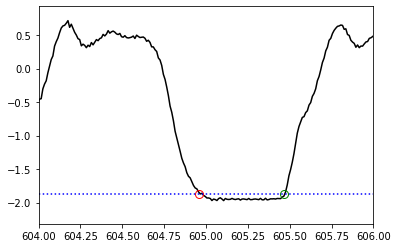

In [8]:
# find start and stop times for each step in time series x
# minduration in sec.
def segment_steps(times,x, min_duration):
    start_times = []
    end_times = []
    
    # adapt threshold to min + a percent of (range of x)
    x_min = np.percentile(x,1) 
    x_max = np.percentile(x,99)
    percent_range = 0.05
    threshold = x_min + (x_max-x_min)*percent_range
    
    # detect up and down crossings     
    mask = np.diff(1*(x > threshold)) # 1 if crosses threshold up, -1 if crosses down
    start_times = times[:-1][mask>0] 
    end_times = times[:-1][mask<0] 
    
    # drop potential endings that occur before first start
    end_times = [end_time for end_time in list(end_times) if end_time > list(start_times)[0]]
    # drop potential starts that occur after the last ending
    start_times = [start_time for start_time in list(start_times) if start_time < list(end_times)[-1]]
        
    # eliminate false alarms (ie. consecutive starts or stops within a short time window, ex. 0.1s)
    start_times, end_times = zip(*[(start_time,end_time) for start_time,end_time in zip(start_times,end_times) if (end_time-start_time) > (min_duration*1000)])
    
    return start_times, end_times, threshold

#test    
rs_step_data_1 = resample_all_cols(step_data_1,sr,100)
de_step_data_1 = detrend_all_cols(rs_step_data_1)

times = de_step_data_1.time
x = de_step_data_1.z_left
start_times, end_times, threshold = segment_steps(times,x, 0.1)
plt.plot(times/1000, x, 'k')
plt.plot(np.array(start_times)/1000,[threshold]*len(start_times), 'go', markersize=8, markerfacecolor='None')
plt.plot(np.array(end_times)/1000,[threshold]*len(end_times), 'ro', markersize=8, markerfacecolor='None')
plt.plot([times.min()/1000,times.max()/1000],[threshold,threshold],'b:')
plt.xlim([604,606])

#### List individual steps in a Dataframe

In [9]:
def steps_from_treadmill_data(treadmill_data, old_sr=1000, new_sr=100, min_duration=0.1):
# takes raw treadmill data (row: one sample, with timestamp and values on x_left,y_left, etc.)
# downsample it from old_sr to new_sr
# detrend it
# segment left steps from z_left, and right steps from z_right
# and list all steps (tagged as left/right) in a new dataframe

    # resample treadmill data
    rs_treadmill_data = resample_all_cols(treadmill_data,old_sr,new_sr)
    # detrend
    de_treadmill_data = detrend_all_cols(rs_treadmill_data)
    
    # segment steps from each foot
    foots = ['left','right']
    foot_features = ['z_left','z_right']
    dimensions = ['x','y','z']
    
    # grow dataframe of steps 
    dataframe_cols = defaultdict(list) # dictionary of {col: list of values}
    for (foot,foot_feature) in zip(foots, foot_features): 
        
        # extract start and end times for current foot, using foot_feature
        start_times, end_times, threshold = segment_steps(de_treadmill_data.time,
                                                          de_treadmill_data[foot_feature],
                                                          min_duration=min_duration)
        
        # for each step, extract treadmill data along all dimensions (x,y,z)
        for start_time,end_time in zip(start_times,end_times): 
 
            for dimension in dimensions: 
                feature = '%s_%s'%(dimension,foot) # ex. x_left 
                step_data_for_dimension = list(de_treadmill_data[(de_treadmill_data.time >=start_time)&(de_treadmill_data.time <end_time)][feature])
                dataframe_cols[dimension].append(step_data_for_dimension)
            
            dataframe_cols['start'].append(start_time/1000) # time in secs
            dataframe_cols['end'].append(end_time/1000) # time in secs
            dataframe_cols['foot'].append(foot)
            
    steps = pd.DataFrame(dataframe_cols)
    
    return steps

steps_2 = steps_from_treadmill_data(step_data_2)

In [452]:
steps_2

,x,y,z,start,end,foot
0,"[-0.4052848148112963, -0.3593281825648025, -0....","[-1.2250302887336837, -1.2690286723900228, -1....","[-1.1137354003813849, -1.0475766770679125, -0....",0.100099,1.200099,left
1,"[-0.4670903395343956, -0.2850246653673135, 0.0...","[-1.2406914484584555, -1.2466538984854836, -1....","[-1.1009570810462483, -1.032928162555689, -0.9...",1.730099,2.620099,left
2,"[-0.6369368495567289, -0.2122297689333754, 0.1...","[-1.192386844854867, -1.1398630610378773, -1.2...","[-1.110938194495503, -1.0098738654973038, -0.8...",3.030099,3.900099,left
3,"[-0.40522373658933286, -0.03979478026149344, 0...","[-1.283649062388246, -1.2477377763068285, -1.2...","[-1.095165240861, -0.9797233754282968, -0.8859...",4.500099,5.590099,left
4,"[-0.5776284545046634, -0.3211564478980986, -0....","[-1.368189150141805, -1.3586399370908602, -1.3...","[-1.1160776468237175, -1.0107552765070487, -0....",6.170099,7.210099,left
...,...,...,...,...,...,...
1501,"[0.02890171973776834, -0.23285928307684145, -0...","[-0.29552346246962014, -0.3421815666433421, -0...","[-0.9823537980530748, -0.892462438653214, -0.8...",1212.570099,1213.660099,right
1502,"[-0.01838417542213744, -0.286921092680827, -0....","[-0.32202294144902943, -0.29774796696300343, -...","[-1.0158424342037928, -0.9408736742135162, -0....",1214.260099,1215.310099,right
1503,"[0.039496919882958004, -0.18266686502198315, -...","[-0.323998672266671, -0.3081555975763659, -0.3...","[-1.005369760695423, -0.9324373253188414, -0.8...",1215.860099,1216.920099,right
1504,"[0.004278569953541478, -0.24429648702723572, -...","[-0.30785106971149934, -0.3735506332490426, -0...","[-1.0095457395388667, -0.8620809383772954, -0....",1217.460099,1218.770099,right


#### Merge with sound events

In [10]:
def merge_step_data_with_sounds(step_data,sound_data): 
# take df of individual steps (with start and end_times, and treadmill data as lists) 
# and join on sound events where sound.time is in [start,end]
# uses a sql join (because pandas doesn't join on >= and <=), and for this convert list columns to strings

    # convert data columns to str for the SQL operation
    dimensions = ['x','y','z']
    step_data[dimensions] = step_data[dimensions].applymap(str)
    
    sound_data['sound_id']= sound_data.index
    
    query = """
    SELECT step_data.*, sound_data.*
    FROM sound_data INNER JOIN step_data
    ON (sound_data.time >= step_data.start AND sound_data.time < step_data.end)
    ORDER BY sound_data.time
    """
    mixed_data = sqldf(query, locals())
    
    # convert back to list of float
    for dimension in dimensions: 
        mixed_data[dimension]=mixed_data[dimension].apply(lambda row: [float(d) for d in row[1:-1].split(',')]  )
    
    # add previous sound and it's pitch
    #previous_sounds = [""]
    #previous_pitchs = [0] + [prev_p for prev_p in mixed_data['pitch'].iloc[:len(mixed_data['pitch'])-1]]
    #list_of_previous_sounds = [sounds for sounds in mixed_data['sound_played'].iloc[:len(mixed_data['sound_played'])-1]]

    #for sound in (list_of_previous_sounds):
    #    previous_sounds.append(sound)
        
    #mixed_data['previous_sounds'] = previous_sounds
    #mixed_data['previous_pitchs'] = previous_pitchs
    
    return mixed_data

merged_data_2 = merge_step_data_with_sounds(steps_2,sound_data_2)


In [75]:
merged_data_2

,x,y,z,start,end,foot,time,sound_played,origin,note,octave,dynamics,pitch,shift,sound_id
0,"[-0.4052848148112963, -0.3593281825648025, -0....","[-1.2250302887336837, -1.2690286723900228, -1....","[-1.1137354003813849, -1.0475766770679125, -0....",0.100099,1.200099,left,0.293367,transformed/Piano.mf.D4.t.shift+0.wav,transformed,D4,4,mf,295.600000,0,0
1,"[-0.4052848148112963, -0.3593281825648025, -0....","[-1.2250302887336837, -1.2690286723900228, -1....","[-1.1137354003813849, -1.0475766770679125, -0....",0.100099,1.200099,left,1.106996,transformed/Piano.mf.Gb3.t.shift+30.wav,transformed,Gb3,3,mf,189.149475,30,1
2,"[0.0038963172609269847, -0.23088366277964223, ...","[-0.22131478824380446, -0.2690658640421697, -0...","[-0.9771868912536466, -0.8908629238372452, -0....",0.960099,1.940099,right,1.106996,transformed/Piano.mf.Gb3.t.shift+30.wav,transformed,Gb3,3,mf,189.149475,30,1
3,"[-0.4670903395343956, -0.2850246653673135, 0.0...","[-1.2406914484584555, -1.2466538984854836, -1....","[-1.1009570810462483, -1.032928162555689, -0.9...",1.730099,2.620099,left,1.915570,transformed/Piano.mf.C4.t.shift-20.wav,transformed,C4,4,mf,260.275742,-20,2
4,"[0.0038963172609269847, -0.23088366277964223, ...","[-0.22131478824380446, -0.2690658640421697, -0...","[-0.9771868912536466, -0.8908629238372452, -0....",0.960099,1.940099,right,1.915570,transformed/Piano.mf.C4.t.shift-20.wav,transformed,C4,4,mf,260.275742,-20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,"[-0.8339492599016163, -0.606289745361567, -0.2...","[-1.095594644908062, -1.0811747620725654, -1.0...","[-1.0742054574825088, -0.9540772368828552, -0....",1211.790099,1212.810099,left,1212.334954,transformed/Piano.mf.Eb4.t.shift-20.wav,transformed,Eb4,4,mf,309.503740,-20,1495
1520,"[0.02890171973776834, -0.23285928307684145, -0...","[-0.29552346246962014, -0.3421815666433421, -0...","[-0.9823537980530748, -0.892462438653214, -0.8...",1212.570099,1213.660099,right,1213.137915,transformed/Piano.mf.Ab3.t.shift+30.wav,transformed,Ab3,3,mf,212.856752,30,1496
1521,"[-0.35671371300896754, -0.10613688514078709, -...","[-1.294344621729557, -1.3344795728887573, -1.2...","[-1.1126850077121078, -0.9651441336497282, -0....",1213.410099,1214.500099,left,1213.950592,transformed/Piano.mf.G3.t.shift+20.wav,transformed,G3,3,mf,199.187868,20,1497
1522,"[-0.01838417542213744, -0.286921092680827, -0....","[-0.32202294144902943, -0.29774796696300343, -...","[-1.0158424342037928, -0.9408736742135162, -0....",1214.260099,1215.310099,right,1214.759762,transformed/Piano.mf.D3.t.shift-30.wav,transformed,D3,3,mf,145.162602,-30,1498


#### Delete duplicates

Some steps are attributed to two or more sound events, e.g. when the next sound starts before the previous step ends. Here, we simply drop (step,sound event) pairs for sound_id duplicates. A more advanced method would e.g. attribute the sound event to the step which has the least distance between sound.time and step.start. 

In [11]:
merged_data_2.drop_duplicates(subset ="sound_id", keep = False, inplace=True)

### Step feature extraction

The goal of this section is to extract features from each step data.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>max_amplitude_left_x</th>
    <th>duration_left_x</th>
    <th>step_data_left_y</th>
    <th>max_amplitude_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>6.8</td>
    <td>1.3</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

#### Zscore step data

In [11]:
def zscore_step_data(step_data): 

    for foot in ['left','right']: 
        
        dimensions = ['x','y','z']
        for dimension in dimensions:
        
            # concatenate all step data in current dimension to compute mean and std
            data_in_dimension = []
            for index, row in step_data[step_data.foot==foot].iterrows():
                data_in_dimension += row[dimension]
            mean_dimension = np.mean(data_in_dimension)
            std_dimension = np.std(data_in_dimension)
        
            #print('%s-%s: M=%.2f,SD=%.2f'%(foot.upper(),dimension,mean_dimension, std_dimension))
        
            # normalize values
            step_data.loc[step_data.foot==foot,dimension+'_zscore'] = step_data[step_data.foot==foot][dimension].apply(lambda row: (row - mean_dimension)/std_dimension)
    
    return step_data
        
zscore_step_data(merged_data_2).z

0       [-2.124657293407579, -2.0584985700941067, -1.9...
1       [-2.124657293407579, -2.0584985700941067, -1.9...
2       [-0.29677552066037494, -0.21045155324397358, -...
3       [-2.1118789740724426, -2.043850055581883, -1.9...
4       [-0.29677552066037494, -0.21045155324397358, -...
                              ...                        
1519    [-2.085127350508703, -1.9649991299090495, -1.7...
1520    [-0.30194242745980315, -0.21205106805994234, -...
1521    [-2.1236069007383023, -1.9760660266759225, -1....
1522    [-0.3354310636105212, -0.2604623036202446, -0....
1523    [-2.1433946869036964, -2.0393673336221307, -1....
Name: z, Length: 1524, dtype: object

#### Extract step duration

<AxesSubplot:>

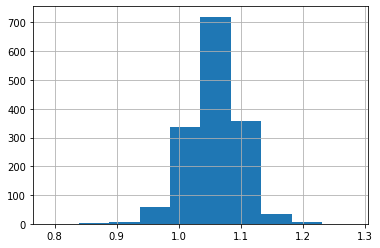

In [12]:
def extract_step_duration(step_data): 

    step_data['step_duration'] = step_data['end'] - step_data['start']
    
    return step_data
        
extract_step_duration(merged_data_2)
merged_data_2.step_duration.hist()

#### Extract weight

In [14]:
def extract_weight(data):
    
    # find reset index, corresponding to change of foot
    reset_index = data[np.append([False],(np.diff(data.time)<0))].index[0]
    
    # tag foot
    data.loc[:reset_index,'foot']='left'
    data.loc[reset_index:,'foot']='right'
    
    # select median as mean weight per foot
    mean_weights = data.groupby(['foot'])[['z_left','z_right']].median().reset_index()
    min_weights = data.groupby(['foot'])[['z_left','z_right']].min().reset_index()
    
    mean_left = float(mean_weights[mean_weights.foot=='left'].z_left)
    min_left = float(min_weights[min_weights.foot=='right'].z_left) # absolute minimum of left treadmill when all weight in on right foot
    
    mean_right = float(mean_weights[mean_weights.foot=='right'].z_right)
    min_right = float(min_weights[min_weights.foot=='left'].z_right)# absolute minimum of right treadmill when all weight in on left foot
    
    return mean_left,min_left,mean_right,min_right

file ='treadmill_4_21_06_01_09_00'
weight_data = pd.read_csv('data/backup/'+file+'_weight.csv')
weight_data = weight_data.apply(pd.to_numeric)
mean_left, min_left,mean_right,min_right= extract_weight(weight_data)
print('mean left: %f, mean right: %f'%(mean_left,mean_right))
print('min left: %f, min right: %f'%(min_left,min_right))
float(mean_left)
       

mean left: -0.456349, mean right: 1.406382
min left: -2.817137, min right: -0.702733


-0.4563488005864196

In [15]:
def fuse_weight_with_steps(step_data,weight_data):
    
    mean_left,min_left,mean_right,min_right = extract_weight(weight_data)
        
    step_data.loc[step_data.foot=='left','weight']=mean_left
    step_data.loc[step_data.foot=='left','minimum']=min_left
    step_data.loc[step_data.foot=='right','weight']=mean_right
    step_data.loc[step_data.foot=='right','minimum']=min_right
    
    
    return step_data

In [16]:
def extract_weight_percentage(data):
    
    data['z_max_percentage'] = (data['z_max']-data['minimum'])/(data['weight']-data['minimum'])*100    
    return data

#### Extract maximum amplitude

In [17]:
def extract_maximum_amplitude(step_data): 

    dimensions = ['x','y','z']
    #previous_dimensions = ['previous_x','previous_y','previous_z']
    
    #for previous_dimension,dimension in zip(previous_dimensions,dimensions):
    for dimension in dimensions: 
        
        step_data[dimension+'_max'] = step_data[dimension].apply(lambda row: np.max(row))
        step_data[dimension+'_max_zscore'] = step_data[dimension+'_zscore'].apply(lambda row: np.max(row))
        #step_data[dimension+'_mean'] = step_data[dimension+'_zscore'].apply(lambda row: np.mean(row))
        #step_data[previous_dimension+'_max'] = [0] + [prev_m for prev_m in step_data[dimension+'_max'].iloc[:len(step_data[dimension+'_max'])-1]]
        #step_data[previous_dimension+'_mean'] = [0] + [prev_m for prev_m in step_data[dimension+'_mean'].iloc[:len(step_data[dimension+'_max'])-1]]
        
    return step_data

The goal of this section is to extract features from each step data.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>max_amplitude_left_x</th>
    <th>duration_left_x</th>
    <th>step_data_left_y</th>
    <th>max_amplitude_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>6.8</td>
    <td>1.3</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

### Add information from previous step

In [18]:
def merge_with_previous_step(data): 

    data['previous_sound_id'] = data['sound_id']-1
    data = data.merge(data,
                      left_on = 'previous_sound_id',
                      right_on = 'sound_id',
                      how='left',
                     suffixes=['','_previous']) 
    
    return data

data = merge_with_previous_step(merged_data_2)


#data#[['sound_id','pitch','previous_sound_id','sound_id_previous','pitch_previous','previous_pitch']]


In [19]:
def extract_differences(data):
    
    # pitch 
    
    data['diff_pitch'] = data.pitch - data.pitch_previous
    data['log_pitch']=data.pitch.apply(np.log)
    data['log_previous_pitch']=data.pitch_previous.apply(np.log)
    data['diff_log_pitch']=data['log_pitch']-data['log_previous_pitch']
    
    # dimensions
    dimensions = ['x','y','z']
    for dimension in dimensions:
        data['diff_'+dimension+'_max_zscore'] = (data[dimension+'_max_zscore']) - (data[dimension+'_max_zscore_previous'])
    data['diff_z_max_percentage'] = data['z_max_percentage']-data['z_max_percentage_previous']
    return data


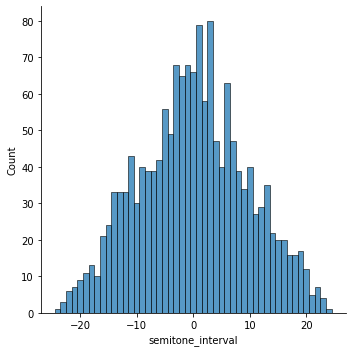

In [20]:
def extract_semitone_interval(data):
    data['semitone_interval']=data.apply(lambda row: np.around(1200*np.log2(abs(row.pitch/row.pitch_previous))/100),
                           axis=1)
    return data

data=extract_semitone_interval(data)

sns.displot(data.semitone_interval,binwidth=1,discrete=True)

## Statistical Analysis

This takes a dataframe in the form:
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_feature</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>2.3</td>
  </tr>
  <tr>
    <td>1</td>
    <td>2</td>
    <td>Bb3</td>
    <td>0.6</td>
  </tr>
  <tr>
    <td>1</td>
    <td>...</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>1</td>
    <td>1500</td>
    <td>C#5</td>
    <td>1.8</td>
  </tr>
</tbody>
</table>

In [21]:
def process_data(file): 
   
    # load data 
    print('load,',end='')
    weight_data = pd.read_csv('data/backup/'+file+'_weight.csv')
    weight_data = weight_data[['time','x_left','y_left','z_left','x_right','y_right','z_right']].apply(pd.to_numeric)
    treadmill_data = pd.read_csv('data/backup/'+file+'.csv')
    treadmill_data = treadmill_data[['time','x_left','y_left','z_left','x_right','y_right','z_right']].apply(pd.to_numeric)
    sound_data = pd.read_csv('data/backup/'+file+'_sound.csv')
    sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)
    
    # segment and merge
    print('segment,',end='')
    data = steps_from_treadmill_data(treadmill_data)
    print('merge,',end='')
    data = merge_step_data_with_sounds(data,sound_data)
    #attention ca ne marche pas pour les repeats
    #il faut changer le droping des doublons lorsque l'on à l'attribut repeat
    print(data[['note']])
    data.drop_duplicates(subset ="sound_id", keep = False, inplace=True) 
    
    # extract features
    print('extract features')
    data = zscore_step_data(data)
    data = extract_step_duration(data)
    data = fuse_weight_with_steps(data,weight_data)
    data = extract_maximum_amplitude(data)
    data = extract_weight_percentage(data)
        
    # add information from previous_step
    
    data = merge_with_previous_step(data)
    data = extract_differences(data)
    data = extract_semitone_interval(data)
    
    return data


#data_1 = process_data('treadmill_1_21_05_06_14_24')
#data_2 = process_data('treadmill_2_21_05_06_15_02')
#data_3 = process_data('treadmill_3_21_05_27_12_01')
#data_4 = process_data('treadmill_4_21_06_01_09_00')
#data_7 = process_data('treadmill_7_21_06_01_11_27')
#data_8 = process_data('treadmill_8_21_06_01_11_59')

data_t = process_data('treadmill_participant_t_order_3_21_06_08_14_01')


load,segment,merge,    note
0     E4
1     E4
2    Gb5
3    Gb5
4    Gb5
..   ...
96   Bb5
97   Bb5
98    C4
99    C4
100   C4

[101 rows x 1 columns]
extract features


In [22]:
def process_data(file): 
   
    # load data 
    print('load,',end='')
    weight_data = pd.read_csv('data/'+file+'_weight.csv')
    weight_data_numeric = weight_data[['time','x_left','y_left','z_left','x_right','y_right','z_right']].apply(pd.to_numeric)
    weight_data_parameters = weight_data[['participant','config_file']]
    weight_data = pd.concat([weight_data_numeric, weight_data_parameters],axis=1)
    print(weight_data)
    treadmill_data = pd.read_csv('data/'+file+'.csv')
    treadmill_data_numeric = treadmill_data[['time','x_left','y_left','z_left','x_right','y_right','z_right']].apply(pd.to_numeric)
    treadmill_data_paramters = treadmill_data[['participant','config_file','order','condition_name']]
    treadmill_data = pd.concat([treadmill_data_numeric, treadmill_data_paramters],axis=1)
    print(treadmill_data)
    sound_data = pd.read_csv('data/'+file+'_sound.csv')
    sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)
    
    # segment and merge
    print('segment,',end='')
    data = steps_from_treadmill_data(treadmill_data)
    print('merge,',end='')
    data = merge_step_data_with_sounds(data,sound_data)
    #attention ca ne marche pas pour les repeats
    #il faut changer le droping des doublons lorsque l'on à l'attribut repeat
    print(data[['note']])
    data.drop_duplicates(subset ="sound_id", keep = False, inplace=True) 
    
    # extract features
    print('extract features')
    data = zscore_step_data(data)
    data = extract_step_duration(data)
    data = fuse_weight_with_steps(data,weight_data)
    data = extract_maximum_amplitude(data)
    data = extract_weight_percentage(data)
        
    # add information from previous_step
    
    data = merge_with_previous_step(data)
    data = extract_differences(data)
    data = extract_semitone_interval(data)
    
    return data


#data_1 = process_data('treadmill_1_21_05_06_14_24')
#data_2 = process_data('treadmill_2_21_05_06_15_02')
#data_3 = process_data('treadmill_3_21_05_27_12_01')
#data_4 = process_data('treadmill_4_21_06_01_09_00')
#data_7 = process_data('treadmill_7_21_06_01_11_27')
#data_8 = process_data('treadmill_8_21_06_01_11_59')

data_t = process_data('treadmill_participant_t_order_3_21_06_08_14_01')


load,

FileNotFoundError: [Errno 2] No such file or directory: 'data/treadmill_participant_t_order_3_21_06_08_14_01_weight.csv'

In [92]:
data_t.semitone_interval

0       NaN
1       0.0
2      14.0
3       0.0
4       0.0
       ... 
96      0.0
97      0.0
98    -23.0
99      0.0
100     0.0
Name: semitone_interval, Length: 101, dtype: float64

(0.0, 5.0)

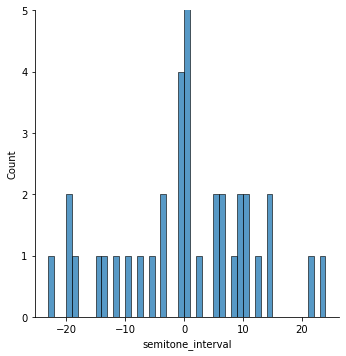

In [91]:
sns.displot(data_t.semitone_interval,
            kind='hist',
            binwidth=1)
plt.ylim([0,5])

In [480]:
data_2.groupby(['foot'])['z_max_percentage'].mean()

foot
left     129.220961
right    117.678595
Name: z_max_percentage, dtype: float64

- work on data collection (ex. repeat sounds x n, have a constant sound x,a,x,b,x,c,etc.)
- work on data preprocessing (ex. z_score, normalize in 0-100%Bw, mean rather than maximum, etc.)
- reverse correlation on z shape (instead of single step feature like max)


### Correlation with single note

#### Step #i with note #i

TODO: 
- rather than zscore, do min-max in 0,1
- classifier les diff pitchs en intervalles (avec le nb de cents[centaine]) pour identifier les quintes, tierces,...

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.888689,0.001852,479.761592,0.000000,0.00564,0.004963,0.885055,0.892322
1,diff_log_pitch,-0.009560,0.003312,-2.886457,0.003953,0.00564,0.004963,-0.016056,-0.003063


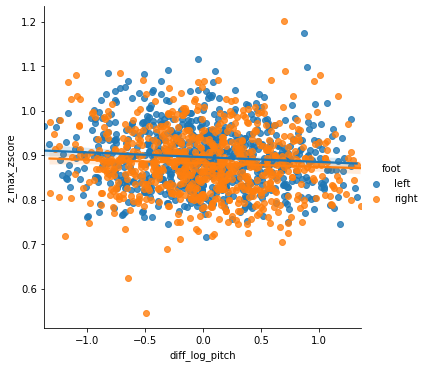

In [482]:
data = data_2
sns.lmplot(data=data,
           x='diff_log_pitch',
           y='z_max_zscore',
           hue='foot')
#plt.ylim([0.85,0.92])
#plt.xscale('log')



pg.linear_regression(data.diff_log_pitch, data.z_max_zscore,remove_na=True)


#### Correlation with pitch and step duration

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.053590,0.014978,70.340421,0.000000,0.000136,-0.000542,1.024209,1.082971
1,log_pitch,0.001208,0.002699,0.447676,0.654453,0.000136,-0.000542,-0.004085,0.006501


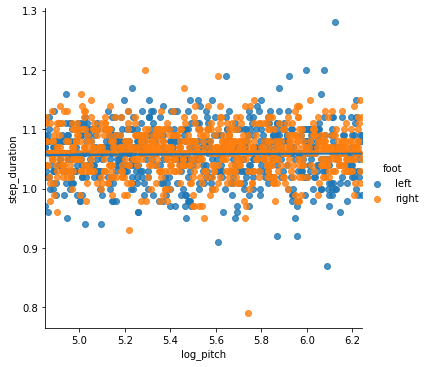

In [19]:
sns.lmplot(data=data,
           x='log_pitch',
           y='step_duration',
           hue='foot')
#plt.ylim([0.85,0.92])
#plt.xscale('log')

pg.linear_regression(data.log_pitch, data.step_duration)

### Correlation with difference between successive notes

#### Correlation with pitch difference and max amplitude

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.888689,0.001852,479.761592,0.000000,0.00564,0.004963,0.885055,0.892322
1,diff_log_pitch,-0.009560,0.003312,-2.886457,0.003953,0.00564,0.004963,-0.016056,-0.003063


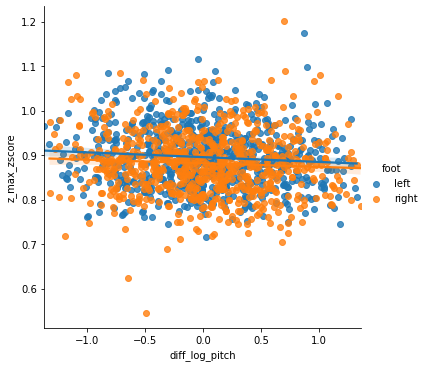

In [484]:
data = data_2
sns.lmplot(data=data,
           x='diff_log_pitch',
           y='z_max_zscore',
           hue='foot')
#plt.ylim([0.85,1.2])
#plt.xscale('log')

pg.linear_regression(data.diff_log_pitch, data.z_max_zscore, remove_na=True)


#### Correlation with pitch difference and max amplitude difference

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.000125,0.002592,-0.048265,0.961511,0.009018,0.008343,-0.005210,0.004960
1,diff_log_pitch,-0.016946,0.004635,-3.656128,0.000265,0.009018,0.008343,-0.026037,-0.007854


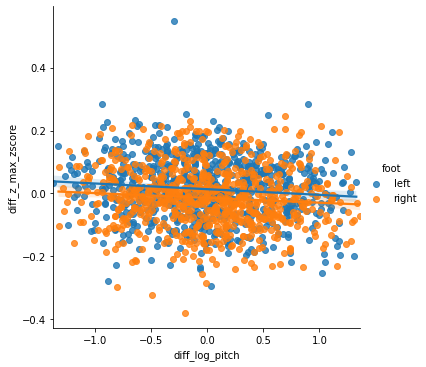

In [486]:
data = data_2
sns.lmplot(data=data,
           x='diff_log_pitch',
           y='diff_z_max_zscore',
           #col='foot',
          hue='foot')
#plt.ylim([1.6,2])
#plt.xscale('log')

pg.linear_regression(data.diff_log_pitch, data.diff_z_max_zscore,remove_na=True)

0             NaN
1             NaN
2        5.375767
3      -10.715727
4        9.465606
          ...    
1471     5.461078
1472    -7.676440
1473    10.464449
1474    -8.737318
1475    10.781658
Name: diff_z_max_percentage, Length: 1476, dtype: float64

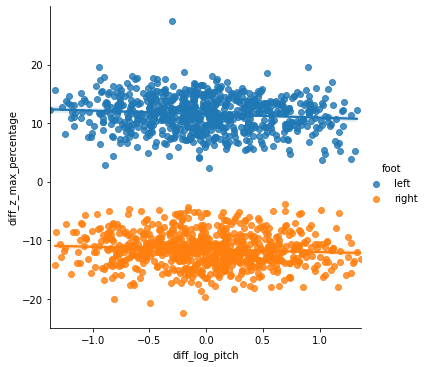

In [494]:
data = data_2
sns.lmplot(data=data,
           x='diff_log_pitch',
           y='diff_z_max_percentage',
           #col='foot',
          hue='foot')
#plt.ylim([1.6,2])
#plt.xscale('log')

pg.linear_regression(data[data.foot=='left'].diff_log_pitch, data[data.foot=='left'].diff_z_max_percentage,remove_na=True)
data.diff_z_max_percentage

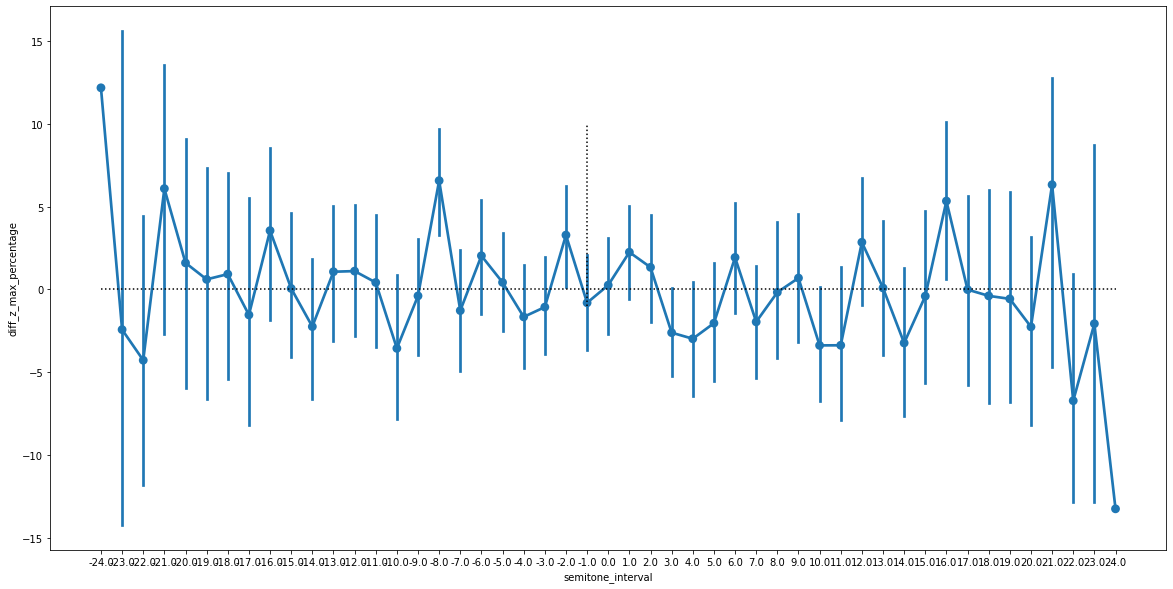

In [495]:
fig = plt.figure(figsize=(20,10))
data = data_2
sns.pointplot(data=data,
           x='semitone_interval',
           y='diff_z_max_percentage')
plt.plot([0,48],[0,0],'k:')
plt.plot([23,23],[-1,10],'k:')


In [211]:
tread_file = "data/treadmill_2_21_05_06_15_02.csv"
sound_file = "data/treadmill_2_21_05_06_15_02_sound.csv"

In [212]:
step=pd.read_csv(tread_file)
sound=pd.read_csv(sound_file)

(110.0, 120.0)

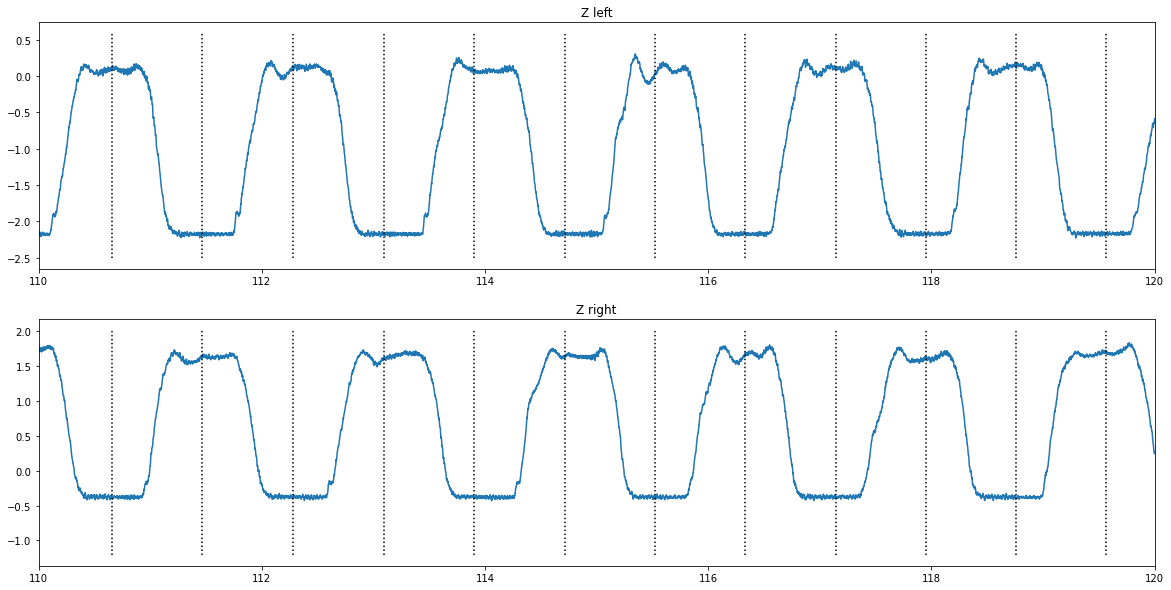

In [213]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(2,1,1)
plt.plot(step['time']/1000,step['z_left'])
plt.title('Z left')
for id,row in sound.iterrows(): 
    plt.plot([row.time,row.time],[step.z_left.min(),step.z_left.max()],'k:')
plt.xlim([110,120])

ax = fig.add_subplot(2,1,2)
plt.plot(step['time']/1000,step['z_right'])
plt.title('Z right')
for id,row in sound.iterrows(): 
    plt.plot([row.time,row.time],[step.z_right.min(),step.z_right.max()],'k:')
plt.xlim([110,120])

